## Applying PINN to the PDE

We are interessed in solving

$$
\frac{\partial \rho}{\partial t} = \nabla \cdot \left(\Sigma \nabla\rho(x,t) - \rho(x,t) F(\rho(x,t)) \right)

$$



Where $x=(x_1,x_2)$. $\Sigma = \rm{diag} (\sigma_1^2, \sigma_2^2)$. $F: \mathbb{R} \mapsto \mathbb{R}^2$, $F(\rho) = f(\rho)e_1$ and $e_1 = (1 \ 0)^T$.

On the domain

$$
\Omega = \{(x_1, x_2) \in [0,L] \times [-l, l]\}
$$

With boundary conditions

$$
j \cdot n = -a (\rho_{max} - \rho) \quad \forall x \in \Gamma_{in}
$$

$$
j \cdot n = b \rho \quad \forall x \in \Gamma_{out}
$$

$$
j \cdot n = 0 \quad \forall x \in \Gamma_{N}
$$


where

$$
\Gamma_{in} = \{(x_1, x_2) \in \Omega: x_1 = 0\}
$$

$$
\Gamma_{out} = \{(x_1, x_2) \in \Omega: x_1 = L\}
$$

$$
\Gamma_{N} = \{(x_1, x_2) \in \Omega: x_2 = \pm l\}
$$

With $j = -\Sigma \nabla \rho + \rho F(\rho)$ and $n$ the outer normal vector, i.e. vector points toward the interior:

$$
n = \begin{pmatrix}
  -1\ 0
\end{pmatrix}^T \quad \rm{for} \quad \Gamma_{in}
$$

$$
n = \begin{pmatrix}
  1\ 0
\end{pmatrix}^T \quad \rm{for} \quad \Gamma_{out}
$$

$$
n = \begin{pmatrix}
  0\ 1
\end{pmatrix}^T \quad \textrm{for upper wall}
$$

$$
n = \begin{pmatrix}
  0\ -1
\end{pmatrix}^T \quad \textrm{for lower wall}
$$

In a more explicit manner, the PDE can be written as

$$
\frac{\partial \rho}{\partial t} = \sigma_1 \frac{\partial^2 \rho}{\partial x_1^2} + \sigma_2 \frac{\partial^2 \rho}{\partial x_2^2} - \frac{\partial \rho}{\partial x_1} \left(f(\rho(x,t)) + \rho(x,t) \frac{d f(\rho(x,t))}{d \rho} \right)
$$

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import equinox as eqx

import optax

import timeit

from scipy.stats import qmc

In [12]:
# Correct that to import from the other file

from abc import ABC, abstractmethod

class FundamentalDiagram():
    def __init__(self, params):
        self.params = params

    def __call__(self,density):
        return self.flux(density)
    
    @abstractmethod
    def flux(self, density):
        pass

    @abstractmethod
    def __str__(self):
        pass



class Greenshield(FundamentalDiagram):
    def __init__(self, params):
        super().__init__(params)
        self.v_max = self.params[0]
        self.p_max = self.params[1]
    
    def flux(self, density):
        return self.v_max * (1 - (density/self.p_max))
    
    def d_flux(self, density):
        return - self.v_max/self.p_max + 0*density
    
    def __str__(self):
        return "Greenshield"

In [13]:
model_key = jax.random.PRNGKey(1)

input_dim = 3
output_dim = 'scalar'

layers_size = 10
n_layers = 1

model = eqx.nn.MLP(in_size=input_dim, out_size=output_dim, width_size=layers_size, depth=n_layers,
                    activation=jax.nn.sigmoid, use_final_bias=False, key=model_key)

In [14]:
# input = (x1, x2, t)

In [82]:
sigma1 = 0.5*0.5
sigma2 = 0.5*0.5

L = 2
l = 0.5
T = 5

a = 0.9
b = 0.5


v_max = 1.2
p_max = 4

In [83]:
func = Greenshield([v_max, p_max])

In [84]:
# Example batch input

batch_input_data = jnp.array([
    [1.0, 2.0, 0.5],
    [3.0, 4.0, 0.7],
    [5.0, 6.0, 0.3]
])

In [85]:
def pde_loss(model, func, input, sigma1, sigma2):
    
    # p = rho

    rho, grad = jax.vmap(jax.value_and_grad(model))(input)
    hess = jax.vmap(jax.hessian(model))(input)

    dp_dx1 = grad[:, 0] 
    dp_dt = grad[:, 2]
    d2p_dx12 = hess[:, 0, 0]
    d2p_dx22 = hess[:, 1, 1]

    fp = func.flux(rho)
    df_p = func.d_flux(rho)

    rhs = sigma1*d2p_dx12 + sigma2*d2p_dx22 - dp_dx1 * (fp + rho*df_p)

    return jnp.mean((dp_dt - rhs)**2)

In [86]:
pde_loss(model, func, batch_input_data,  sigma1=sigma1, sigma2=sigma2)

Array(0.28644577, dtype=float32)

In [87]:
def j(model, func, input, sigma1, sigma2):
    rho, grad = jax.vmap(jax.value_and_grad(model))(input)

    i_0 = - sigma1*grad[:, 0] + rho * func(rho)
    i_1 = - sigma2*grad[:, 1]

    return i_0, i_1, rho

In [88]:
def walls_loss(model, func, l, L, T, sigma1, sigma2, steps=20):
    x1 = jnp.linspace(0, L, steps)
    t = jnp.linspace(0, T, steps)

    X1_grid, T_grid = jnp.meshgrid(x1, t)

    x1_flat = X1_grid.flatten()
    t_flat = T_grid.flatten()
    x2_flat_positive = jnp.full_like(x1_flat, l)
    x2_flat_negative = jnp.full_like(x1_flat, -l)


    result_positive = jnp.stack((x1_flat, x2_flat_positive, t_flat), axis=-1)
    result_negative = jnp.stack((x1_flat, x2_flat_negative, t_flat), axis=-1)

    _ , upper, _ = j(model, func, result_positive, sigma1, sigma2)
    _ , lower, _ = j(model, func, result_negative, sigma1, sigma2)


    #return upper
    return jnp.mean(upper**2 + lower**2)

In [89]:
walls_loss(model, func, l, L, T, sigma1, sigma2)

Array(0.04878369, dtype=float32)

In [90]:
def in_loss(model, func, l, T, sigma1, sigma2, a, steps=20):

    x2 = jnp.linspace(-l, l, steps)
    t = jnp.linspace(0, T, steps)

    X2_grid, T_grid = jnp.meshgrid(x2, t)

    x2_flat = X2_grid.flatten()
    t_flat = T_grid.flatten()
    x1_flat = jnp.zeros_like(x2_flat)

    result = jnp.stack((x1_flat, x2_flat, t_flat), axis=-1)

    in_ , _, rho = j(model, func, result, sigma1, sigma2)

    in_theorical = -a * (func.p_max - rho)




    return jnp.mean((-in_ - in_theorical)**2)


In [91]:
in_loss(model, func, l, T, sigma1, sigma2, a)

Array(0.21647511, dtype=float32)

In [121]:
def out_loss(model, func, l, L, T, sigma1, sigma2, b, steps=20):

    x2 = jnp.linspace(-l, l, steps)
    t = jnp.linspace(0, T, steps)

    X2_grid, T_grid = jnp.meshgrid(x2, t)

    x2_flat = X2_grid.flatten()
    t_flat = T_grid.flatten()
    x1_flat = jnp.full_like(x2_flat, L)

    result = jnp.stack((x1_flat, x2_flat, t_flat), axis=-1)

    out_ , _, rho = j(model, func, result, sigma1, sigma2)

    out_theorical = b * rho




    return jnp.mean((out_ - out_theorical)**2)

In [122]:
out_loss(model, func, L, l, T, sigma1, sigma2, b)

Array(0.03418251, dtype=float32)

In [124]:
def time_loss(model, l, L, steps=20):

    x1 = jnp.linspace(0, L, steps)
    x2 = jnp.linspace(-l, l, steps)

    X1_grid, X2_grid = jnp.meshgrid(x1, x2)

    x1_flat = X1_grid.flatten()
    x2_flat = X2_grid.flatten()
    t_flat = jnp.zeros_like(x2_flat)

    result = jnp.stack((x1_flat, x2_flat, t_flat), axis=-1)

    rho = jax.vmap(model)(result)

    return jnp.mean(rho**2)

In [125]:
time_loss(model, l, L)

Array(0.04392358, dtype=float32)

In [230]:
def loss(model, func, input, l, L, T, sigma1, sigma2, a, b, steps=20):

    return (walls_loss(model, func, l, L, T, sigma1, sigma2, steps) +
            in_loss(model, func, l, T, sigma1, sigma2, a, steps) + out_loss(model, func, L, l, T, sigma1, sigma2, b, steps) + 
            time_loss(model, l, L, steps))

    #return time_loss(model, l, L, steps)

In [231]:
loss(model, func, batch_input_data, l, L, T, sigma1, sigma2, a, b)

Array(0.04925239, dtype=float32)

In [232]:
# Define a Multilayer Perceptron

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-1]:
            x = jax.nn.softplus(layer(x))
        x = self.layers[-1](x)
        return x

In [233]:
# Define a Multilayer Perceptron With a Skip Connection

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.
    gate: eqx.nn.Linear  # Learnable gating mechanism


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 2)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

        # Skip connection
        self.gate = eqx.nn.Linear(1, 1, key=keys[-1]) # Linear layer for the third input

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """

        skip_connection = x # Copy of input


        for layer in self.layers[:-1]:
            x = jax.nn.sigmoid(layer(x))
            
        x = self.layers[-1](x)

        # Apply the skip connection

        gate_input = skip_connection[2].reshape(1, 1)  # Reshape to match gate input dimensions
        gate_output = self.gate(gate_input)

        x = x * gate_output

        return x.squeeze() 

In [234]:
def generate_latin_hypercube_samples(num_samples, x1, x2, t):
    # Define the ranges
    parameter_ranges = jnp.array([x1, x2, t])
    
    # Create a Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d=len(parameter_ranges))
    
    # Sample points in the hypercube
    sample_points = sampler.random(n=num_samples)
    
    # Scale the points
    scaled_samples = qmc.scale(sample_points, parameter_ranges[:, 0], parameter_ranges[:, 1])
    
    return jnp.array(scaled_samples)

In [235]:
generate_latin_hypercube_samples(10, [0,L], [-l,l], [0,T])

Array([[ 0.6636403 ,  0.25620908,  4.035728  ],
       [ 1.3505154 ,  0.42716667,  4.741586  ],
       [ 0.45676744, -0.2759313 ,  0.71862596],
       [ 1.0843239 , -0.1361747 ,  2.2414076 ],
       [ 0.87707293,  0.3376015 ,  1.4177188 ],
       [ 0.20658468, -0.0301923 ,  2.8638105 ],
       [ 1.957134  ,  0.01632917,  3.9925673 ],
       [ 0.05431437, -0.4103561 ,  3.0654287 ],
       [ 1.4939775 ,  0.12555225,  0.0103209 ],
       [ 1.790397  , -0.3862622 ,  1.8302498 ]], dtype=float32)

In [236]:
# Initialize the model with multiple hidden layers and scalar output layer
model_key = jax.random.PRNGKey(1)


output_dim = 'scalar'

model = MLP(model_key, input_dim=input_dim, hidden_dims=500, n_layers=2, output_dim=output_dim)

In [237]:
# Optimizer definition
lr = 0.001
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(model)

In [238]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, func, input, l, L, T, sigma1, sigma2, a, b, steps=20):
    loss_value, grads = jax.value_and_grad(loss)(model, func, input, l, L, T, sigma1, sigma2, a, b, steps) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [239]:
# Training loop
num_epochs = 10000
losses = []



sample_n = 50
x = generate_latin_hypercube_samples(sample_n, [0,L], [-l,l], [0,T]) # Latin Hypercube sample

sample_points = x.copy()

for epoch in range(num_epochs):
    
    model, opt_state, loss_value = train_step(model, opt_state, func, x, l, L, T, sigma1, sigma2, a, b, steps=20)
    if epoch % 100 == 0:
        x = generate_latin_hypercube_samples(sample_n, [0,L], [-l,l], [0,T]) # Latin Hypercube sample
        sample_points = jnp.vstack((sample_points, x))
        losses.append(loss_value)
        print(f"Epoch {epoch}, Loss: {loss_value}")


    if epoch % 1000 == 0:
        lr *= 0.45
        optimizer = optax.adam(learning_rate=lr)
        opt_state = optimizer.init(model)  # Re-initialize optimizer state with new learning rate

        

# Print final loss
x = generate_latin_hypercube_samples(sample_n, [0,L], [-l,l], [0,T]) # Latin Hypercube sample
final_loss = loss(model, func, x, l, L, T, sigma1, sigma2, a, b, steps=20)
print(f"Final Loss: {final_loss}")

Epoch 0, Loss: 7.923731803894043
Epoch 100, Loss: 0.8932534456253052
Epoch 200, Loss: 0.8341742753982544
Epoch 300, Loss: 0.7752888798713684
Epoch 400, Loss: 0.7053406238555908
Epoch 500, Loss: 0.6368539929389954
Epoch 600, Loss: 0.5787384510040283
Epoch 700, Loss: 0.5247810482978821
Epoch 800, Loss: 0.463478147983551
Epoch 900, Loss: 0.38716423511505127
Epoch 1000, Loss: 0.3074760437011719
Epoch 1100, Loss: 0.26596471667289734
Epoch 1200, Loss: 0.22970356047153473
Epoch 1300, Loss: 0.19872082769870758
Epoch 1400, Loss: 0.16078835725784302
Epoch 1500, Loss: 0.0957837849855423
Epoch 1600, Loss: 0.02659878507256508
Epoch 1700, Loss: 0.0226955134421587
Epoch 1800, Loss: 0.018176639452576637
Epoch 1900, Loss: 0.02846907265484333
Epoch 2000, Loss: 0.01641063392162323
Epoch 2100, Loss: 0.025491029024124146
Epoch 2200, Loss: 0.016456857323646545
Epoch 2300, Loss: 0.014456106349825859
Epoch 2400, Loss: 0.013694792054593563
Epoch 2500, Loss: 0.01298876665532589
Epoch 2600, Loss: 0.0122982524335

: 

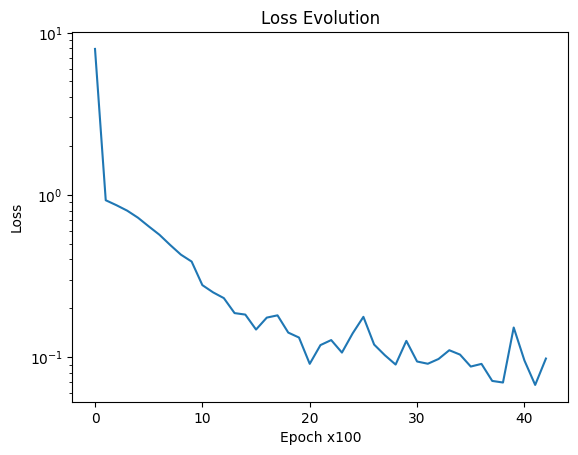

In [212]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch x100')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.show()

In [213]:
out_loss(model, func, L, l, T, sigma1, sigma2, b)

Array(0.0302239, dtype=float32)

In [214]:
print(pde_loss(model, func, batch_input_data,  sigma1=sigma1, sigma2=sigma2))
print(walls_loss(model, func, l, L, T, sigma1, sigma2))
print(in_loss(model, func, l, T, sigma1, sigma2, a))
print(out_loss(model, func, L, l, T, sigma1, sigma2, b))
print(time_loss(model, l, L))

2.7039924
0.0021697287
0.00457479
0.0302239
0.012283973


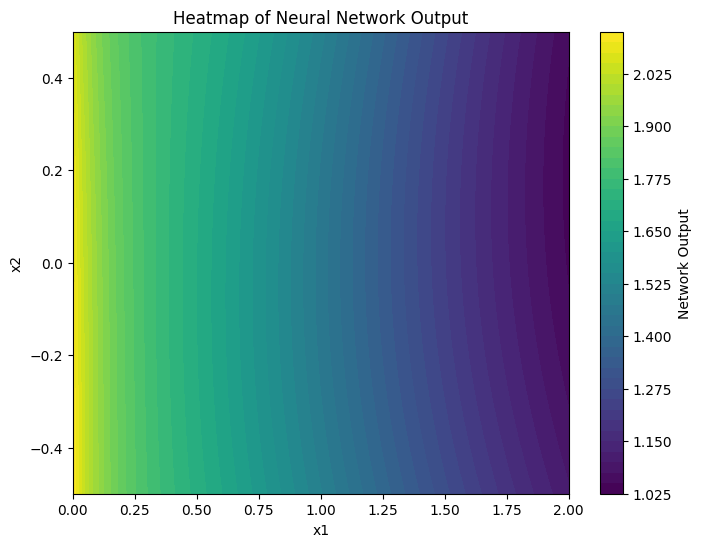

In [229]:
# Define a function to evaluate the network on a grid
def evaluate_on_grid(neural_network, x1_range, x2_range, x3_fixed, num_points_x1, num_points_x2):
    # Create equally spaced points for x1 and x2
    x1 = jnp.linspace(*x1_range, num_points_x1)
    x2 = jnp.linspace(*x2_range, num_points_x2)
    
    # Create a meshgrid
    X1_grid, X2_grid = jnp.meshgrid(x1, x2)
    
    # Flatten the grids
    x1_flat = X1_grid.flatten()
    x2_flat = X2_grid.flatten()
    
    # Create the constant x3 array
    x3_flat = jnp.full_like(x1_flat, x3_fixed)
    
    # Stack the inputs together
    inputs = jnp.stack((x1_flat, x2_flat, x3_flat), axis=-1)
    
    # Evaluate the network on each input
    outputs = jnp.array([neural_network(inp) for inp in inputs])
    
    # Reshape the outputs to match the grid
    outputs_grid = outputs.reshape(num_points_x2, num_points_x1)
    
    return X1_grid, X2_grid, outputs_grid

# Example usage
params = None  # Replace with actual parameters of your network
x1_range = (0, L)
x2_range = (-l, l)
x3_fixed = 1
num_points_x1 = 50
num_points_x2 = 50

X1_grid, X2_grid, outputs_grid = evaluate_on_grid(model, x1_range, x2_range, x3_fixed, num_points_x1, num_points_x2)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(X1_grid, X2_grid, outputs_grid, levels=50, cmap='viridis')
plt.colorbar(label='Network Output')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Heatmap of Neural Network Output')
plt.show()

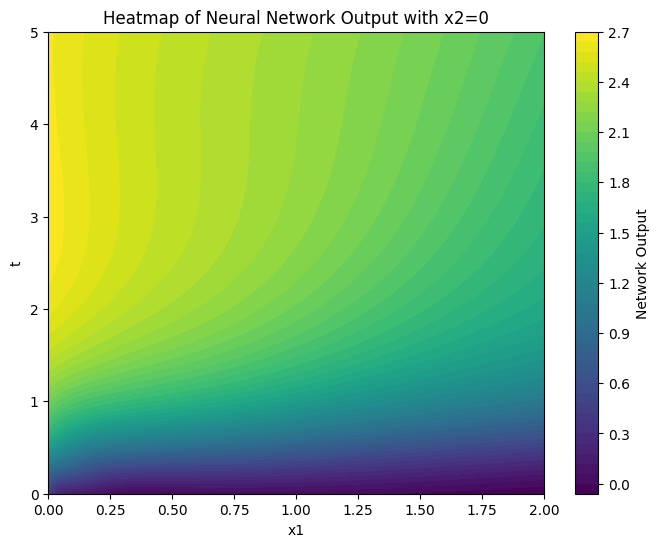

In [216]:
def evaluate_on_grid(neural_network, x1_range, x3_range, x2_fixed, num_points_x1, num_points_x3):
    # Create equally spaced points for x1 and x3
    x1 = jnp.linspace(*x1_range, num_points_x1)
    x3 = jnp.linspace(*x3_range, num_points_x3)
    
    # Create a meshgrid
    X1_grid, X3_grid = jnp.meshgrid(x1, x3)
    
    # Flatten the grids
    x1_flat = X1_grid.flatten()
    x3_flat = X3_grid.flatten()
    
    # Create the constant x2 array
    x2_flat = jnp.full_like(x1_flat, x2_fixed)
    
    # Stack the inputs together
    inputs = jnp.stack((x1_flat, x2_flat, x3_flat), axis=-1)
    
    # Evaluate the network on each input
    outputs = jnp.array([neural_network(inp) for inp in inputs])
    
    # Reshape the outputs to match the grid
    outputs_grid = outputs.reshape(num_points_x3, num_points_x1)
    
    return X1_grid, X3_grid, outputs_grid

# Example usage
params = None  # Replace with actual parameters of your network
x1_range = (0, L)
x3_range = (0, T)
x2_fixed = 0
num_points_x1 = 100
num_points_x3 = 100

X1_grid, X3_grid, outputs_grid = evaluate_on_grid(model, x1_range, x3_range, x2_fixed, num_points_x1, num_points_x3)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(X1_grid, X3_grid, outputs_grid, levels=50, cmap='viridis')
plt.colorbar(label='Network Output')
plt.xlabel('x1')
plt.ylabel('t')
plt.title('Heatmap of Neural Network Output with x2=0')
plt.show()

In [81]:
d=0.1
t = 1

In [67]:
jax.vmap(jax.hessian(model))(batch_input_data)

Array([[[-1.02314341e+00,  3.05922389e-01,  1.33926924e-02],
        [ 3.05922389e-01, -1.29695415e-01,  3.87590945e-01],
        [ 1.33926757e-02,  3.87590855e-01,  5.11156507e-02]],

       [[-4.40914668e-02,  2.27595959e-02, -1.22350045e-01],
        [ 2.27595549e-02,  1.96366664e-02,  1.02300480e-01],
        [-1.22350037e-01,  1.02300458e-01,  5.46588041e-02]],

       [[-2.78910622e-04, -1.52377207e-02, -6.98310584e-02],
        [-1.52377021e-02,  3.24197598e-02,  6.34557456e-02],
        [-6.98310435e-02,  6.34557828e-02,  5.15914783e-02]]],      dtype=float32)